In [51]:
import os
import numpy as np
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from keras.models import load_model
from keras import Model
from tensorflow.keras.saving import save_model
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from scipy.stats import randint, uniform

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_curve, auc, confusion_matrix

In [2]:
data_dir = '..\dataset'
classes = ('REAL', 'FAKE')

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_images = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    subset="training",
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary')

val_images = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    subset="validation",
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary')

test_images = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary')

Found 80000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [5]:
model = load_model('../models/DILATED_NADAM')

In [6]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, None, None, 32)    896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, None, None, 32)   0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, None, None, 32)    0         
                                                                 
 conv2d_13 (Conv2D)          (None, None, None, 64)    18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, None, None, 64)   0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, None, None, 64)   

In [7]:
new_model = Model(inputs=model.input, outputs=model.get_layer('dense_8').output)

In [8]:
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12_input (InputLayer  [(None, None, None, None  0        
 )                           )]                                  
                                                                 
 conv2d_12 (Conv2D)          (None, None, None, 32)    896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, None, None, 32)   0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, None, None, 32)    0         
                                                                 
 conv2d_13 (Conv2D)          (None, None, None, 64)    18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, None, None, 64)   0     

In [9]:
x_train = []
y_train = []
for batch_id in range(len(train_images)):
    batch_images = train_images[batch_id][0]
    batch_labels = train_images[batch_id][1]
    features = new_model.predict(batch_images)
    y_train.extend(batch_labels)
    x_train.extend(features)

1/1 [==============================] - 0s 61ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 46ms/step


In [10]:
x_val = []
y_val = []
for batch_id in range(len(val_images)):
    batch_images = val_images[batch_id][0]
    batch_labels = val_images[batch_id][1]
    features = new_model.predict(batch_images)
    y_val.extend(batch_labels)
    x_val.extend(features)

1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 43ms/step


In [11]:
x_test = []
y_test = []
for batch_id in range(len(test_images)):
    batch_images = test_images[batch_id][0]
    batch_labels = test_images[batch_id][1]
    features = new_model.predict(batch_images)
    y_test.extend(batch_labels)
    x_test.extend(features)

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 43ms/step


In [12]:
knn_params = {
    'n_neighbors': randint(1, 21),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['brute', 'kd_tree'],
    'leaf_size': randint(20, 50),
    'p': [1, 2]
}
logreg_params = {
    'C': uniform(loc=0, scale=1),  
    'penalty': ['l1', 'l2'],  
    'solver': ['liblinear', 'saga']  
}
gnb_params = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5] 
}


In [13]:
knn_model = KNeighborsClassifier()
logreg_model = LogisticRegression()
svc_model = SVC()
gnb_model = GaussianNB()

In [14]:
cnn_f_knn_random = RandomizedSearchCV(knn_model, knn_params, cv=5, n_jobs=-1, n_iter=10)
cnn_f_knn_random.fit(x_train, y_train)
cnn_feat_knn_model = cnn_f_knn_random.best_estimator_

In [15]:
cnn_feat_logreg_random = RandomizedSearchCV(logreg_model, logreg_params, cv=5, n_jobs=-1, n_iter=10)
cnn_feat_logreg_random.fit(x_train, y_train)
cnn_feat_logreg_model = cnn_feat_logreg_random.best_estimator_

In [18]:
cnn_feat_gnb_random = RandomizedSearchCV(gnb_model, gnb_params, cv=5, n_jobs=-1, n_iter=10, verbose=2)
cnn_feat_gnb_random.fit(x_train, y_train)
cnn_feat_gnb_model = cnn_feat_gnb_random.best_estimator_

C:\Users\uajhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [20]:
knn_pred = cnn_feat_knn_model.predict(x_test)
logreg_pred = cnn_feat_logreg_model.predict(x_test)
gnb_pred = cnn_feat_gnb_model.predict(x_test)

In [25]:
algorithms = ['KNN Classifier', 'Logistic Regressor', 'Gaussian NB']
predictions = [knn_pred, logreg_pred, gnb_pred]

In [53]:
accuracy_scores = []
f1_scores_list = []
precision_scores = []
recall_scores = []

In [54]:
for pred in predictions:
    accuracy_scores.append(accuracy_score(y_test, pred))
    f1_scores_list.append(f1_score(y_test, pred))
    precision_scores.append(precision_score(y_test, pred))
    recall_scores.append(recall_score(y_test, pred))

In [55]:
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
data = {
    'Algorithm': algorithms,
    'Accuracy': accuracy_scores,
    'F1 Score': f1_scores_list,
    'Precision': precision_scores,
    'Recall': recall_scores
}

In [57]:
import pandas as pd
df = pd.DataFrame(data)

In [60]:
df_melted = df.melt('Algorithm', var_name='Metric', value_name='Value')

C:\Users\uajhi\AppData\Local\Temp\ipykernel_12032\944687000.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x="Algorithm", y="Value", hue="Metric", data=df_melted, ci=None)


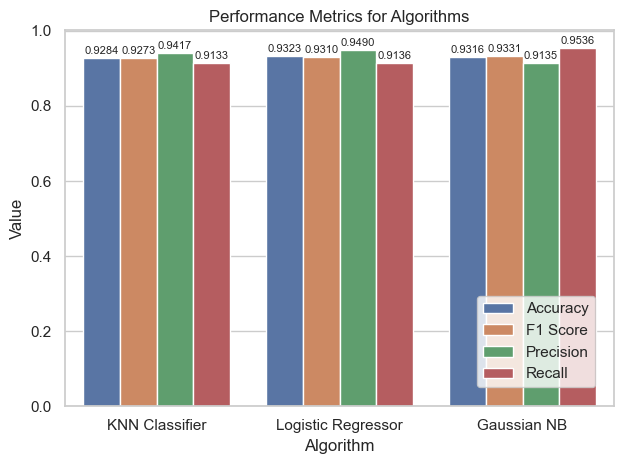

In [78]:
sns.set(style="whitegrid")
ax = sns.barplot(x="Algorithm", y="Value", hue="Metric", data=df_melted, ci=None)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points', fontsize=8)

plt.title('Performance Metrics for Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('Value')
plt.legend(bbox_to_anchor=(.75, .05), loc='lower left', borderaxespad=0.)
plt.tight_layout()
plt.show()

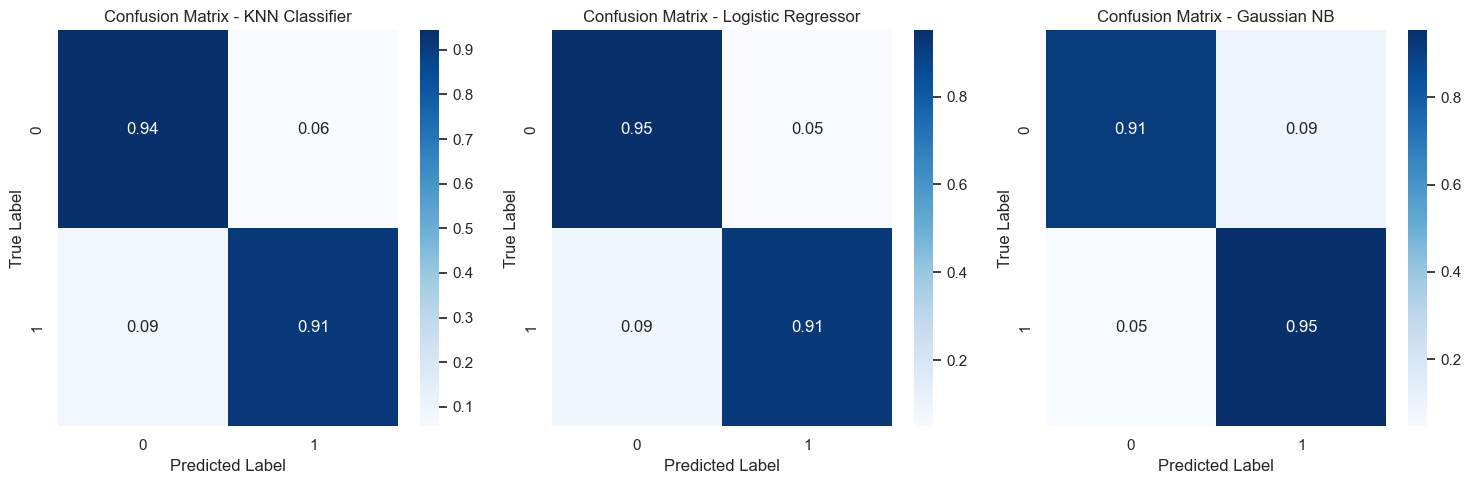

In [80]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(len(algorithms)):
    algorithm = algorithms[i]
    prediction = predictions[i]

    cm = confusion_matrix(y_test, prediction)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix

    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {algorithm}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout()
plt.show()

In [81]:
import pickle

In [82]:
with open('../models/KNN.pkl', 'wb') as file:
    pickle.dump(cnn_feat_knn_model, file)

In [83]:
with open('../models/LOGISITIC.pkl', 'wb') as file:
    pickle.dump(cnn_feat_logreg_model, file)

In [84]:
with open('../models/GNB.pkl', 'wb') as file:
    pickle.dump(cnn_feat_gnb_model, file)